# Projekt Analiza Danych 
## Mateusz Kłos 240705
### 2023/2024 zima

## Informacje projektowe
[Link do strony z danymi](https://data.world/data-society/used-cars-data)
- Projekt zajmuje się wyznaczeniem szacunkowej ilości dni jaką samochód spędzi na internetowym portalu z ogłoszeniami przed jego sprzedażą.
- Dane wykorzystywane do trenowania regresorów/estymatorów wyznaczających oczekiwane wartości pochodzą z niemieckiego eBay'a a ogłoszenia z okresu od 2014 do 2016 roku.
- Działania podejmowane w projekcie skupią się na poznaniu i opisaniu danych jak i również próbie uzyskania lepszych estymacji poprzez dokładniejsze zbadanie danych i zmianę parametrów funkcji wykorzystywanych do estymacji.

## Obróbka danych
Dane podczas wczytywania zostały poddane wielu powtarzającym się operacjom. W tym pliku zostaną wymienione jedynie pojedyncze typy operacji by uniknąć powtórzeń. Wszystkie operacje można zobaczyć w pliku projektowym **handle_data.py** znajdującym się w folderze **ad_project**.

### Struktura wczytania i obróbki danych w pliku **main.py**

In [ ]:
from handle_data import read_data, translate_data, change_column_types, create_y_column, modify_data, encode_columns

if __name__ == '__main__':
    df = read_data('autos.csv')
    df = translate_data(df)
    df = create_y_column(df)
    df = modify_data(df)
    df = change_column_types(df)

    df_encoded = encode_columns(df)

### Przykłady operacji podjętych w funkcjach
- **read_data**
  - wczytanie pliku oraz zmiana nazw kolumn

In [3]:
import pandas as pd

def read_data(filename):
    df = pd.read_csv(filename, encoding='latin-1')
    
    column_mapping = {
        'dateCrawled': 'date_crawled',
        'offerType': 'offer_type'
    }
    df.rename(columns=column_mapping, inplace=True)
    return df

/var/folders/p1/ymfcyq356ps69w3ypg4l2_h4r7tjsl/T/ipykernel_37911/1103894515.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


- **translate_data**
    - przetłumaczenie danych z języka niemieckiego na angielski:

In [ ]:
def translate_data(df):
    df['unrepaired_damage'] = df['unrepaired_damage'].replace(['ja', 'nein'], ['yes', 'no'])
    df['gearbox'] = df['gearbox'].astype('category')

- **create_y_column**
  - stworzenie kolumny wynikowej mówiącej o ilości dni spędzonych w serwisie przez ogłoszenie na podstawie daty utworzenia oraz zniknięcia ogłoszenia

In [2]:
def create_y_column(df):
    df['ad_created'] = pd.to_datetime(df['ad_created'])
    df['last_seen'] = pd.to_datetime(df['last_seen'])
    df['days_online'] = (df['last_seen'] - df['ad_created']).dt.days
    df = df.drop(['last_seen'], axis=1)
    df = df.drop(['ad_created'], axis=1)

- **modify_data**
  - pozbycie się nieistotnych kolumn
  - filtracja danych na podstawie zakresu wartości lub braku wartości
  - usunięcie danych nie wprowadzających żadnych informacji np. typ samochodu - inny

In [3]:
def modify_data(df):
    df = df.drop(['offer_type'], axis=1)
    df = df.drop(['date_crawled'], axis=1)
    df = df[df.unrepaired_damage.notna()]
    df = df[df.vehicle_type != 'andere']
    df = df[df.fuel_type != 'andere']
    df = df[df.days_online > 0]

- **change_column_types**
  - ustawienie odpowiednich kategorii dla kolumn, które zostały automatycznie wykryte jako tekstowe

In [2]:
def change_column_types(df):
    df['seller'] = df['seller'].astype('category')
    df['vehicle_type'] = df['vehicle_type'].astype('category')

#### By móc przeprowadzić predykcję należy również przeprowadzi zakodowanie kolumn posiadających wartości tekstowe

In [1]:
def encode_columns(df):
    label_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'unrepaired_damage']
    df_encoded = df.copy()
    label_encoder = LabelEncoder()
    for column in label_columns:
        df_encoded[column] = label_encoder.fit_transform(df[column])

    return df_encoded

#### Po tych modifikacjach ilość wierszy danych wynosi: **216577**

## Przedstawienie danych

#### Funkcje zajmujące się wyświetlaniem danych znajdują sie w pliku **display_data.py**

In [4]:
def plot_statistics(df):
    for column in df.columns:
        if df[column].dtype == 'category':
            plt.figure(figsize=(8, 8))
            df[column].value_counts(normalize=True).plot(kind='bar', color='lightblue', edgecolor='black')
            plt.ylabel('procent')
            plt.title(f'Dystrybucja znormalizowana {column}')
            plt.show()
        else:
            max_value = df[column].max()
            min_value = df[column].min()
            avg_value = df[column].mean()

            plt.figure(figsize=(8, 8))
            df[column].hist(bins=40, color='lightblue', edgecolor='black')
            plt.axvline(max_value, color='red', linestyle='dashed', linewidth=2, label='Max')
            plt.axvline(min_value, color='green', linestyle='dashed', linewidth=2, label='Min')
            plt.axvline(avg_value, color='orange', linestyle='dashed', linewidth=2, label='Średnia')
            plt.title(f'Dystrybucja {column} z wartościami min, max i średnią')
            plt.xlabel('wartość')
            plt.ylabel('ilość')
            plt.legend()
            plt.show()

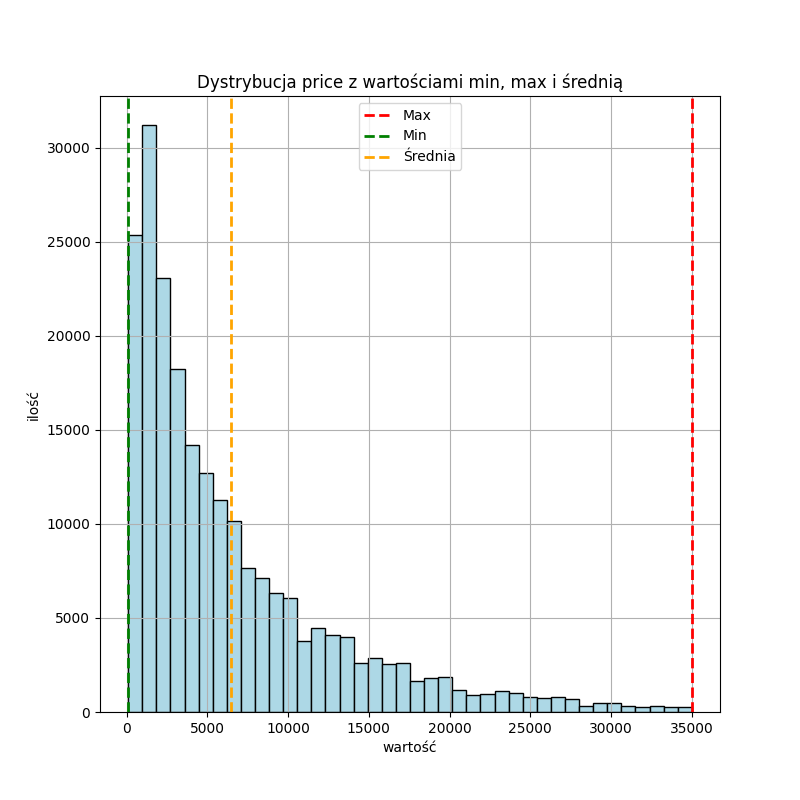
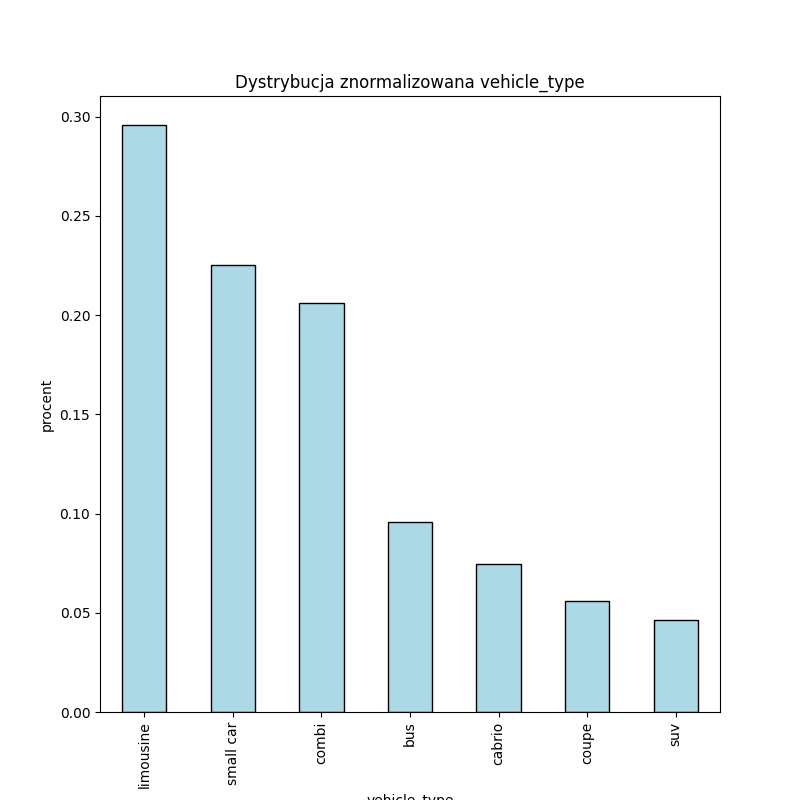
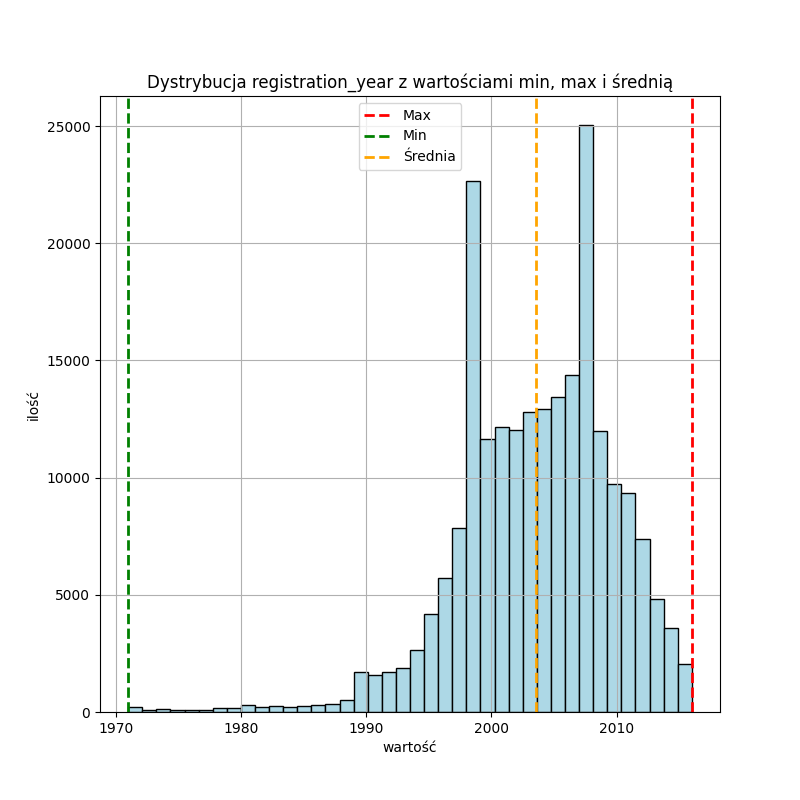
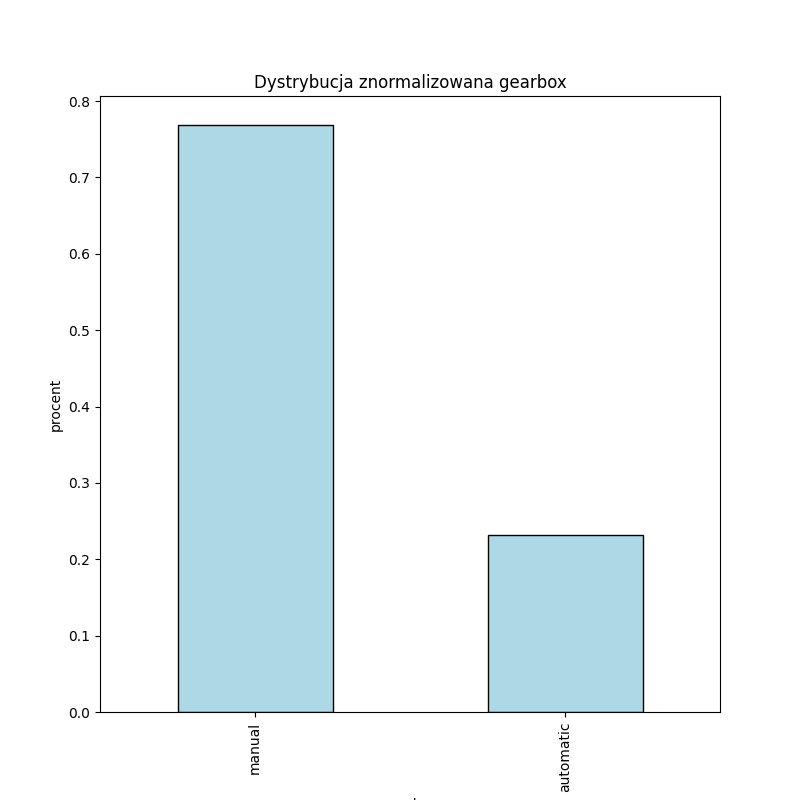
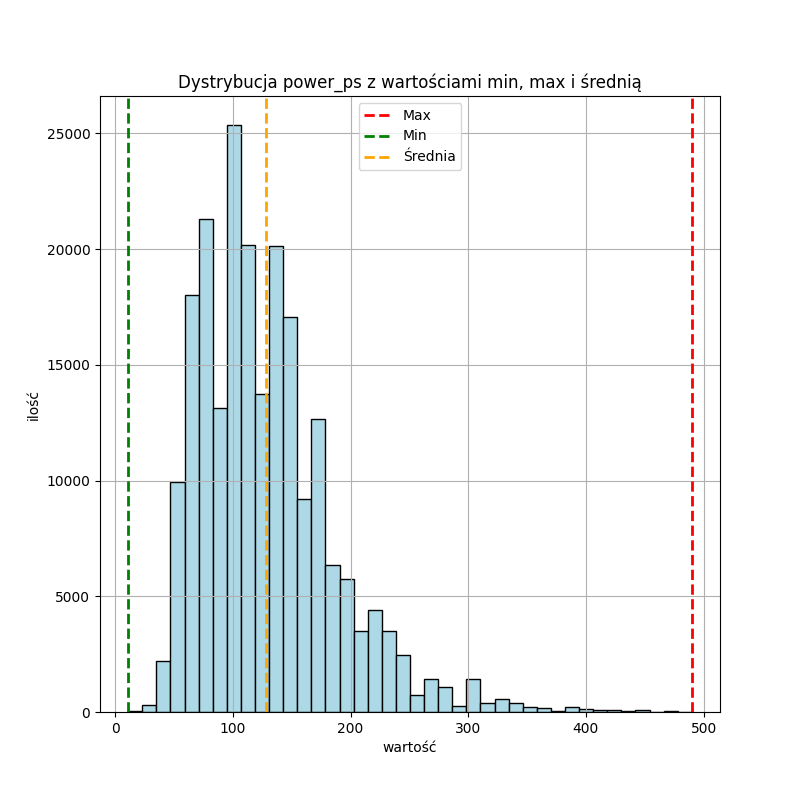
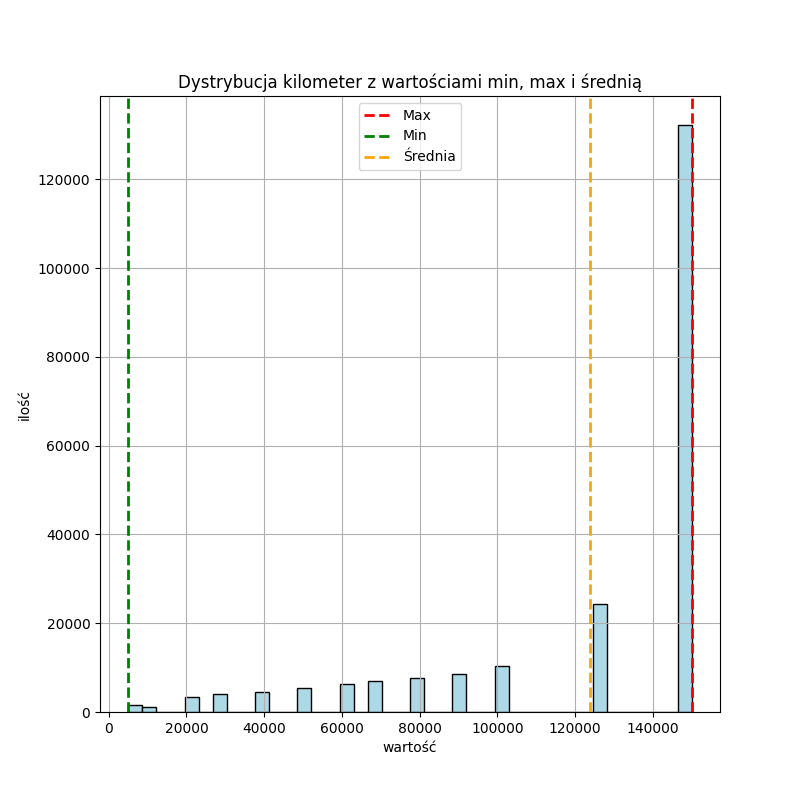
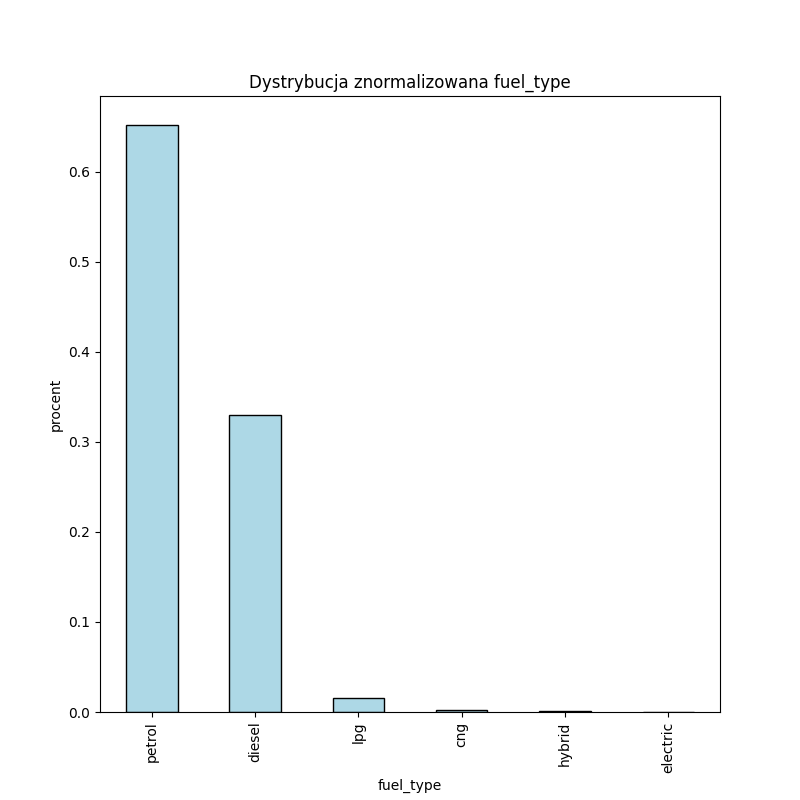
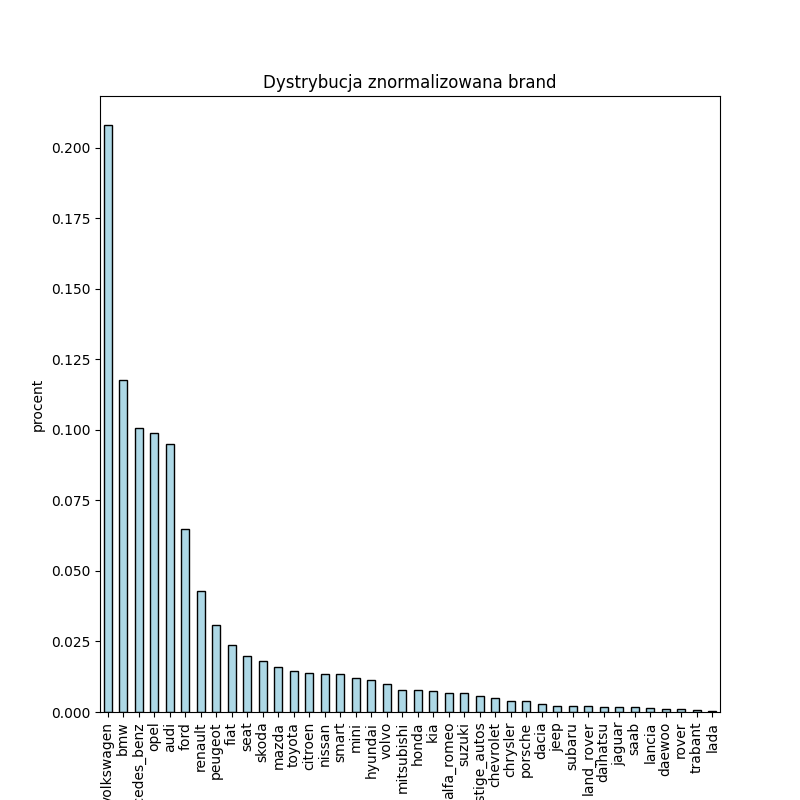
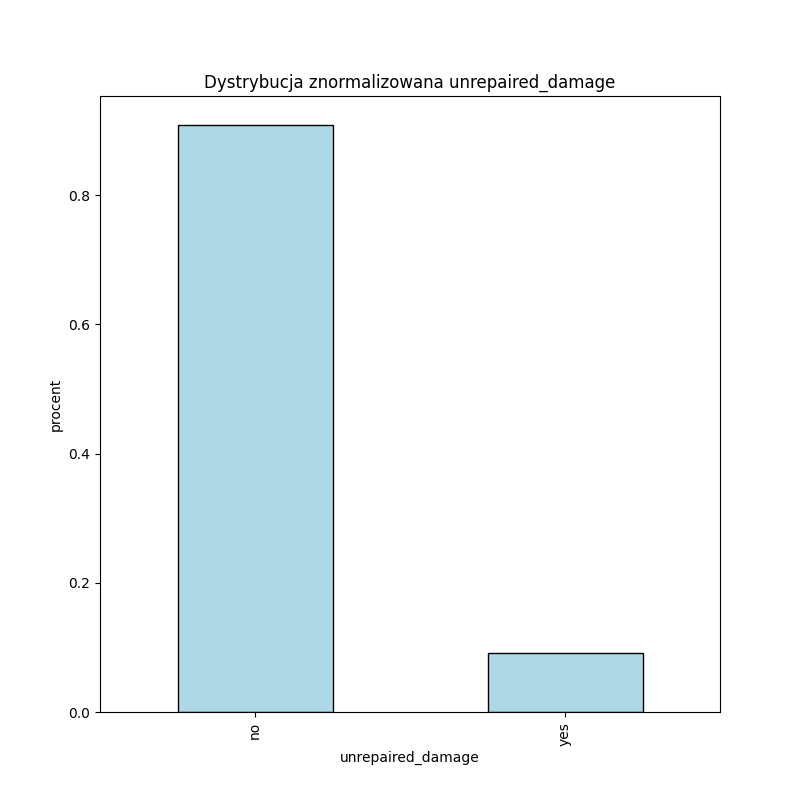
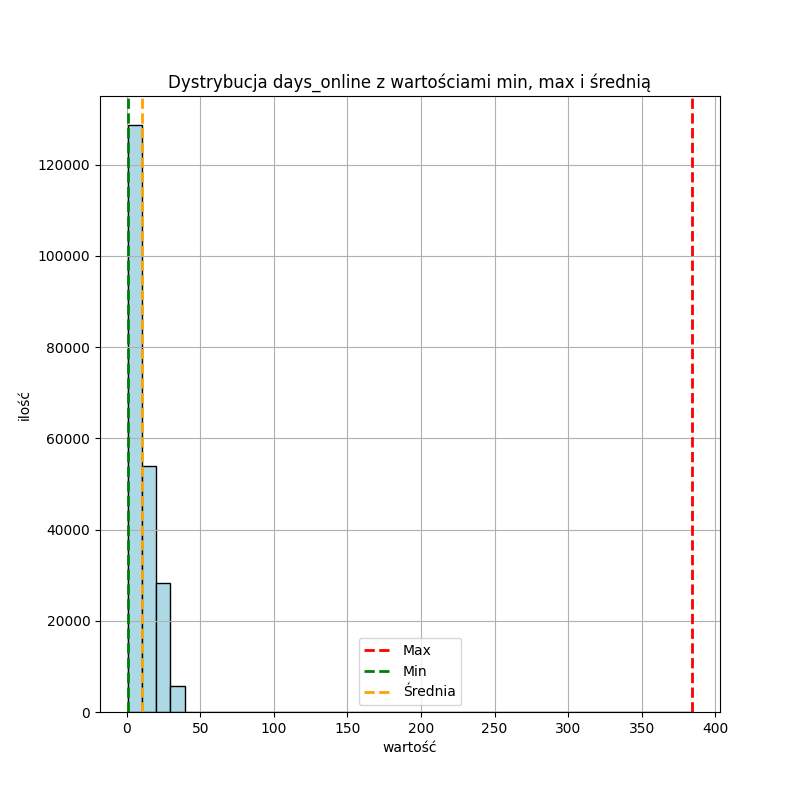

### Wnioski z przedstawienia danych
- 76% sprzedawanych samochodów posiada manualną skrzynię biegów.
- Samochody benzynowe oraz diesel stanowią ponad 90% sprzedawanych samochodów.
- Najpopularniejsza marka volkswagen występuje prawie dwa razy więcej niż druga z najpopularniejszych.
- 86% samochodów nie posiada nienaprawionych szkód.
- 75% samochodów spędza do 16 dni na aukcji, natomiast najwyższa zarejestrowana wartość wynosi 384 dni (taka dystrybucja danych może negatywnie wpłynąć na skuteczność przewidywania wyników).

## Wyniki wstępne
#### Początkowe wyniki uzyskane zostały po podzieleniu danych na podstawie funkcji **split_test_train** oraz użyciu **DecisionTreeRegressor** oraz **RandomForestRegressor** z parametrami podstawowymi. Wszystkie funkcje dotyczące treningu, podziału czy predykcji znajdują się w pliku **regression.py**.
#### Przed przystąpieniem do uzyskania wstępnych wyników dane kategoryczne zostały zakodowane przy użyciu funkcji **enocde_columns** i podzielone na kolumny wejściowe i wyjściowe dzięki funkcji **split_data** z pliku **handle_data.py**.

In [ ]:
def encode_columns(df):
    label_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'unrepaired_damage']
    df_encoded = df.copy()
    label_encoder = LabelEncoder()
    for column in label_columns:
        df_encoded[column] = label_encoder.fit_transform(df[column])

    return df_encoded

def split_data(df):
    y = df['days_online']
    x = df.drop(['days_online'], axis=1)

    return x, y

#### Kodowanie i podzielenie pozwoliło uzyskać wstępne wyniki

In [5]:
from handle_data import encode_columns, split_data
from regression import split_test_train, default_tree_regressor, default_random_forest_regressor

df_encoded = encode_columns(df)

x, y = split_data(df)
x_encoded, y_encoded = split_data(df_encoded)
x_encoded_train, x_encoded_test, y_encoded_train, y_encoded_test = split_test_train(x_encoded, y_encoded, 0.3)

mae_default_tree = default_tree_regressor(x_encoded_train, y_encoded_train, x_encoded_test, y_encoded_test)
mae_default_forest = default_random_forest_regressor(x_encoded_train, y_encoded_train, x_encoded_test, y_encoded_test)

ModuleNotFoundError: No module named 'handle_data'

In [6]:
import random

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

def split_test_train(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,
                                                        random_state=random.randint(0, 1_000_000))
    return x_train, x_test, y_train, y_test

def default_tree_regressor(x_train, y_train, x_test, y_test):
    print('Default tree regressor')
    regressor = DecisionTreeRegressor(random_state=random.randint(0, 1_000_000))

    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    mae = median_absolute_error(y_test, y_pred)
    print('Median absolute error: ', mae)

    return mae

def default_random_forest_regressor(x_train, y_train, x_test, y_test):
    print('Default random forest regressor')
    regressor = RandomForestRegressor(random_state=random.randint(0, 1_000_000))

    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    mae = median_absolute_error(y_test, y_pred)
    print('Median absolute error: ', mae)

    return mae

ModuleNotFoundError: No module named 'sklearn'

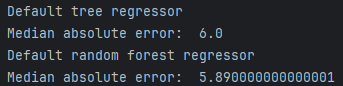

#### Aktualnie możliwe jest określenie czasu od wystawienia do kupna samochodu z medianą błedu wynoszącą +-6 dni dla znalezionych danych. W następnych krokach postaram się ten błąd zmniejszyć. Poszukiwania będą prowadzone dla kryterium uzyskania najmniejszej wartości błędu dla któregokolwiek z klasyfikatorów.
#### W momencie poszukiwania lepszych parametrów/lepszego wyboru kolumn zmienna **random_state** we wszytkich funkcjach, które ją używają została ustawiona na stałą wartość równą **420** by umożliwić powtarzalność wyników.
#### Wszystkie funkcje poszukujące lepszych parametrów/lepszego wyboru kolumn znajdują się w pliku **improve_parameters.py**.

## Ograniczenie kolumn na podstawie ich korelacji z oczekiwanym wynikiem

In [ ]:
from display_data import plot_feature_importance
from improve_parameters import find_best_correlation_threshold

correlations = plot_feature_importance(df_encoded, 'days_online')
best_correlation_threshold = find_best_correlation_threshold(correlations, x_encoded, y_encoded)
columns = correlations[correlations > best_correlation_threshold].index
x_encoded_selected = x_encoded[columns]
x_encoded_selected_train, x_encoded_selected_test, y_encoded_selected_train, y_encoded_selected_test = \
        split_test_train(x_encoded_selected, y_encoded, 0.3)

In [ ]:
def plot_feature_importance(df, target_column):
    correlations = df.drop(columns=[target_column]).corrwith(df[target_column]).abs().sort_values(ascending=False)

    plt.figure(figsize=(8, 8))
    correlations.plot(kind='bar', color='lightblue', edgecolor='black')
    plt.title('Korelacja właściwości z ilością dni online')
    plt.xlabel('Właściwość')
    plt.ylabel('Współczynnik korelacji')
    plt.show()

    return correlations

def find_best_correlation_threshold(correlations, x, y):
    min_median_absolute_error = float('inf')
    best_correlation_threshold = 0

    for threshold in [i / 100 for i in range(int(correlations.max() * 100))]:
        columns = correlations[correlations > threshold].index
        x_selected = x[columns]
        x_train, x_test, y_train, y_test = split_test_train(x_selected, y, 0.3)

        mae_default_tree = default_tree_regressor(x_train, y_train, x_test, y_test)
        mae_default_forest = default_random_forest_regressor(x_train, y_train, x_test, y_test)

        if mae_default_tree < min_median_absolute_error:
            min_median_absolute_error = mae_default_tree
            best_correlation_threshold = threshold
        if mae_default_forest < min_median_absolute_error:
            min_median_absolute_error = mae_default_forest
            best_correlation_threshold = threshold
    
    print('Najlepszy prog korelacji: ', best_correlation_threshold)
    
    return best_correlation_threshold

#### Funkcja **plot_feature_importance** z pliku **display_data.py** wyświetla korelację kolumn wejściowych do kolumny wyjściowej oraz zwraca otrzymane korelacje.
#### Funkcja **find_best_correlation_threshold** z pliku **improve_parameters.py** szuka najlepszego możliwego punktu odcięcia korelacji gdzie wybrane korelacje mają wartość > od danego progu. Progi poruszają się od wartości 0 do wartości maksymalnego punktu odcięcia minus 0.01 z krokiem 0.01.
#### Rezultat obliczenia korelacji:

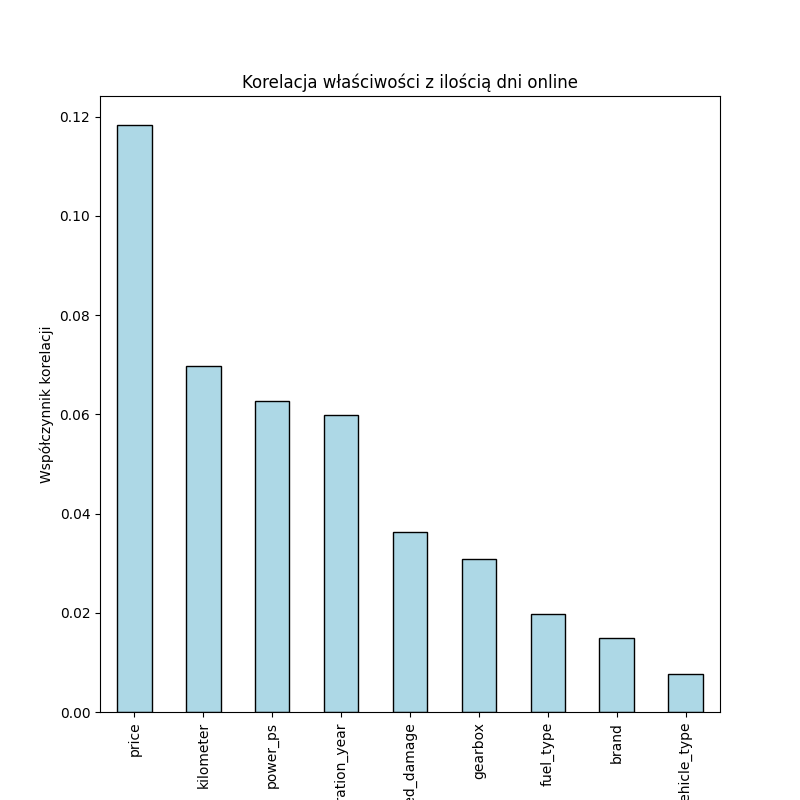

## Wnioski z poszukiwania korelacji cech z kolumną wynikową
- Największą korelację okazuje się odznaczać cecha ceny samochodu. Następne cechy są od niej stosunkowo daleko i same między sobą znajdują się dosyć blisko.
- Na podstawie 10 wywołań funkcji poszukującej najlepszego punktu odcięcia zwracała ona wartości 0.0 lub 0.01 jako najlepsze punkty odcięcia. Co oznacza, że najlepsze wyniki uzyskujemy zostawiając pełny zestaw danych lub odrzucając jedynie typ pojazdu.

## Wyznaczenie najlepszych właściwości estymatorów na podstawie grid_search

In [ ]:
from improve_parameters import grid_search

best_tree_params, best_forest_params = grid_search(x_encoded_train, y_encoded_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

def grid_search(x_train, y_train):
    param_grid_tree = {
        'min_samples_leaf': [10, 30, 50, 80, 100],
        'min_samples_split': [5, 10, 20, 30, 50],
        'max_depth': [5, 10, 20],
    }
    grid_search_tree = GridSearchCV(DecisionTreeRegressor(random_state=420), param_grid_tree,
                                    scoring='neg_median_absolute_error')

    grid_search_tree.fit(x_train, y_train)
    best_params_tree = grid_search_tree.best_params_

    param_grid_forest = {'n_estimators': [100],
                         'min_samples_leaf': [20, 50, 80],
                         'min_samples_split': [5, 10, 20, 30, 50],
                         'max_depth': [5, 10, 20],
                         }
    grid_search_forest = GridSearchCV(RandomForestRegressor(random_state=420),
                                      param_grid_forest, scoring='neg_mean_absolute_error')
    grid_search_forest.fit(x_train, y_train)

    best_params_forest = grid_search_forest.best_params_

    print("Najlepsze parametry DecisionTreeRegressor: ", best_params_tree)
    print("Najlepsze parametry RandomForestRegressor: ", best_params_forest)

    return best_params_tree, best_params_forest

#### Funkcja **grid_search** z pliku **improve_parameters.py** zwraca najlepsze parametry dla drzewa decyzyjnego jak i dla lasu. Poszukuje parametrów pośród podanych przez nas w formie obiektu i ocenia otrzymane wyniki podaną przez nas funkcją. Funkcja oceny w tym przypadku została określona jako absolutna mediana błędu regresji.
#### Wyniki funkcji **grid_search**:

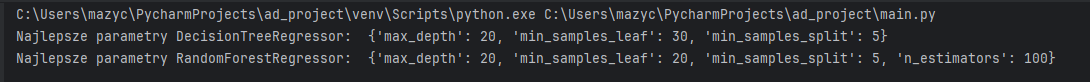

#### Porównanie błędu ustawień wstępnych ze znalezionymi ustawieniami

In [ ]:
from regression import tree_regressor_with_params, random_forest_regressor_with_params

best_tree_params = {'max_depth': 20, 'min_samples_leaf': 30, 'min_samples_split': 5}
best_forest_params = {'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}

print()
mae_best_params_tree = tree_regressor_with_params(x_encoded_train, y_encoded_train, x_encoded_test, y_encoded_test,
                                                      best_tree_params['max_depth'],
                                                      best_tree_params['min_samples_leaf'],
                                                      best_tree_params['min_samples_split'])
mae_best_params_forest = random_forest_regressor_with_params(x_encoded_train, y_encoded_train, x_encoded_test,
                                                                 y_encoded_test, best_forest_params['n_estimators'],
                                                                 best_forest_params['min_samples_leaf'],
                                                                 best_forest_params['min_samples_split'],
                                                                 best_forest_params['max_depth'])

In [ ]:
def tree_regressor_with_params(x_train, y_train, x_test, y_test, max_depth, min_samples_leaf, min_samples_split):
    print('Tree regressor with params: max_depth: ', max_depth, ' min_samples_leaf: ', min_samples_leaf,
          ' min_samples_split: ', min_samples_split)

    regressor = DecisionTreeRegressor(random_state=random.randint(0, 1_000_000),
                                      max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split)

    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    mae = median_absolute_error(y_test, y_pred)
    print('Median absolute error: ', mae)

    return mae

def random_forest_regressor_with_params(x_train, y_train, x_test, y_test, n_estimators, min_samples_leaf,
                                        min_samples_split, max_depth):
    print('Random forest regressor with params: n_estimators: ', n_estimators, ' min_samples_leaf: ', min_samples_leaf,
          ' min_samples_split: ', min_samples_split, ' max_depth: ', max_depth)

    regressor = RandomForestRegressor(random_state=random.randint(0, 1_000_000),
                                      n_estimators=n_estimators, min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split, max_depth=max_depth)

    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    mae = median_absolute_error(y_test, y_pred)
    print('Median absolute error: ', mae)

    return mae

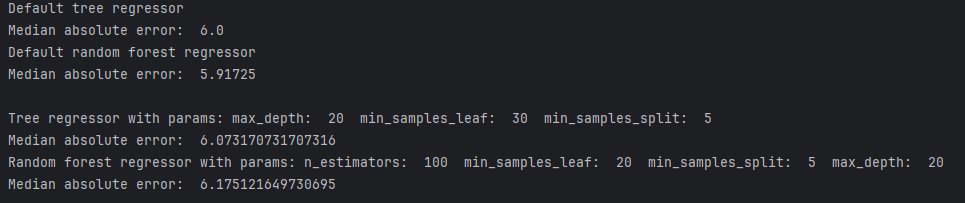

## Wnioski z wyznaczenia najlepszych właściwości estymatorów
- Najepsze znalezione estymatory okazały się gorsze od tych ustawionych automatycznie
- Może to oznaczać nadmierne dopasowanie się do danych przy większej ilości podziałów w przypadku wartości podstawowych jak np. **min_samples_leaf = 1**
- Różnica jest jednak niewielka i może ona być rekompensowana większą stabilnością dzięki mniejszemu dopasowaniu do posiadanych danych

# Wnioski końcowe
Wyznaczenie ilości dni spędzonych przez ogłoszenie samochodowych na portalu z błędem medianowym wynoszącym +-6 dni jest w moim odczuciu zadowalające. Kroki podjęte przeze mające na celu polepszenie tego wyniku nie przyniosły oczekiwanych rezultatów. W trakcie wykonywania tego projektu miałem okazję zagłębić się w wiele stron dokumentacji dotyczących używanych bibliotek wraz z ich funkcjami jak i również przeczytać wiele stron opisujących wykorzystywane przeze mnie sposoby, mechanizmy decyzyjne i wiele innych zagadnień. Znacząco poszerzyło to moją wiedzę w kierunku, w którym do tej pory nie miałem praktycznie żadnego doświadczenia.